## Домашка

In [1]:
%%capture
!pip install --upgrade keras
!pip install torch torchvision torchaudio

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [3]:
import keras
print(keras.__version__)

3.8.0


In [4]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

### Задание 1 (8 баллов)
Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет, но их тоже можно использовать). Как минимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на Recall@Precision меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.

In [5]:
data = pd.read_csv("lenta_40k.csv.zip")

In [6]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [7]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

# индексируем слова
word2id = {"PAD": 0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [8]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint("model.weights.h5", # названия файла
                                                monitor="val_rec@prec", # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode="max", # если метрика должна расти, то тут max и min если наоборот
                                                save_freq="epoch" # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop = keras.callbacks.EarlyStopping(monitor="val_rec@prec",
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode="max",
                                              )

In [9]:
inputs = keras.layers.Input(shape=(MAX_LEN,))

embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)
drop1 = keras.layers.Dropout(0.3)(embeddings)
convs = []
for ks in [3, 5, 7, 9]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding="same", strides=1)(drop1)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=24, padding="same", strides=1,
                                  kernel_regularizer="l2", activation="relu")(conv1)
    pool = keras.layers.AveragePooling1D(pool_size=5)(conv2)
    convs.append(pool)

concat = keras.layers.concatenate(convs, axis=2)

drop2 = keras.layers.Dropout(0.5)(concat)

flatten = keras.layers.Flatten()(drop2)
dense = keras.layers.Dense(50, activation="relu")(flatten)
outputs = keras.layers.Dense(len(label2id), activation="softmax")(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=[keras.metrics.RecallAtPrecision(0.8, name="rec@prec")],
              )

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 200, 100)       │      2,409,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 200, 100)       │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 200, 32)        │          9,632 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 200, 32)        │         16,032 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 200, 32)        │         22,432 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 200, 32)        │         28,832 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 200, 24)        │          2,328 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 200, 24)        │          3,864 │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 200, 24)        │          5,400 │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 200, 24)        │          6,936 │ conv1d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d         │ (None, 40, 24)         │              0 │ conv1d_1[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_1       │ (None, 40, 24)         │              0 │ conv1d_3[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_2       │ (None, 40, 24)         │              0 │ conv1d_5[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_3       │ (None, 40, 24)         │              0 │ conv1d_7[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 40, 96)         │              0 │ average_pooling1d[0][… │
│                           │                        │                │ average_pooling1d_1[0… │
│                           │                        │                │ average_pooling1d_2[0… │
│                           │                        │                │ average_pooling1d_3[0… │
├──────────────────────

 Total params: 2,697,675 (10.29 MB)

 Trainable params: 2,697,675 (10.29 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=2000,
    epochs=100,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 1.1811 - rec@prec: 5.9524e-06
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - loss: 1.1712 - rec@prec: 5.4348e-06 - val_loss: 0.8311 - val_rec@prec: 0.0000e+00
Epoch 2/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.7559 - rec@prec: 3.9235e-05
Epoch 2: val_rec@prec improved from 0.00000 to 0.00361, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - loss: 0.7499 - rec@prec: 5.8523e-05 - val_loss: 0.5368 - val_rec@prec: 0.0036
Epoch 3/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.4866 - rec@prec: 0.0083
Epoch 3: val_rec@prec improved from 0.00361 to 0.22182, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 0.4828 - rec@prec: 0.0102 - val_loss: 0.3485 - val_rec@prec: 0.2218
Epoch 4/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.3142 - rec@prec: 0.2923
Epoch 4: val_rec@

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


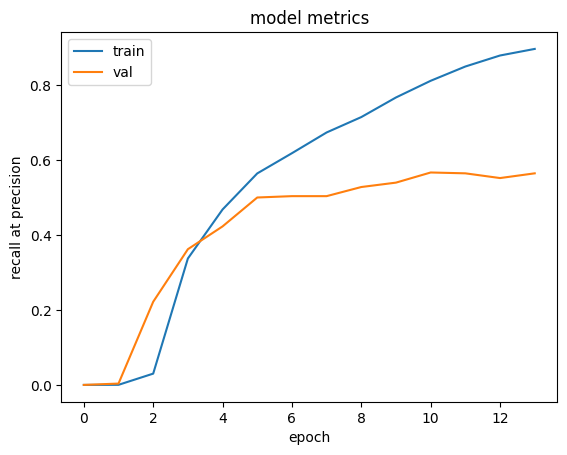

In [12]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history["rec@prec"])
plt.plot(model.history.history["val_rec@prec"])
plt.title("model metrics")
plt.ylabel("recall at precision")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

### Задание 2 (2 балла)
Обучите нейросеть со сверточными слоями с архитектурой похожей на Unet - https://en.wikipedia.org/wiki/U-Net

Не нужно воспроизводить все в точности, главное, чтобы было сокращение длины последовательности с помощью CNN, а затем обратное увеличение длины последовательности до изначальной с residual связями между промежуточными шагами с одинаковыми размерностями.
Изменений размерности должно быть хотя бы 3 и соответственно residual связей тоже.

Для повышения размерности используйте keras.layers.UpSampling1D
Полученная модель должна давать ненулевое качество на той же самой задаче классификации текстов.

In [13]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint("model.weights.h5", # названия файла
                                                monitor="val_rec@prec", # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode="max", # если метрика должна расти, то тут max и min если наоборот
                                                save_freq="epoch" # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop = keras.callbacks.EarlyStopping(monitor="val_rec@prec",
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode="max",
                                              )

In [14]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

# Encoder
conv1 = keras.layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(embeddings)
conv1 = keras.layers.Dropout(0.2)(conv1)
conv1 = keras.layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(conv1)
pool1 = keras.layers.AveragePooling1D(pool_size=2)(conv1)

conv2 = keras.layers.Conv1D(256, kernel_size=3, padding="same", activation="relu")(pool1)
conv2 = keras.layers.Dropout(0.2)(conv2)
conv2 = keras.layers.Conv1D(256, kernel_size=3, padding="same", activation="relu")(conv2)
pool2 = keras.layers.AveragePooling1D(pool_size=2)(conv2)

conv3 = keras.layers.Conv1D(512, kernel_size=3, padding="same", activation="relu")(pool2)
conv3 = keras.layers.Dropout(0.2)(conv3)
conv3 = keras.layers.Conv1D(512, kernel_size=3, padding="same", activation="relu")(conv3)
pool3 = keras.layers.AveragePooling1D(pool_size=2)(conv3)

# Bottleneck
conv4 = keras.layers.Conv1D(1024, kernel_size=3, padding="same", activation="relu")(pool3)
conv4 = keras.layers.Dropout(0.2)(conv4)
conv4 = keras.layers.Conv1D(1024, kernel_size=3, padding="same", activation="relu")(conv4)

# Decoder
up5 = keras.layers.UpSampling1D(size=2)(conv4)
up5 = keras.layers.concatenate([up5, conv3])
conv5 = keras.layers.Conv1D(512, kernel_size=3, padding="same", activation="relu")(up5)
conv5 = keras.layers.Dropout(0.2)(conv5)
conv5 = keras.layers.Conv1D(512, kernel_size=3, padding="same", activation="relu")(conv5)

up6 = keras.layers.UpSampling1D(size=2)(conv5)
up6 = keras.layers.concatenate([up6, conv2])
conv6 = keras.layers.Conv1D(256, kernel_size=3, padding="same", activation="relu")(up6)
conv6 = keras.layers.Dropout(0.2)(conv6)
conv6 = keras.layers.Conv1D(256, kernel_size=3, padding="same", activation="relu")(conv6)

up7 = keras.layers.UpSampling1D(size=2)(conv2)
up7 = keras.layers.concatenate([up7, conv1])
conv7 = keras.layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(up7)
conv7 = keras.layers.Dropout(0.2)(conv7)
conv7 = keras.layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(conv7)

flatten = keras.layers.Flatten()(conv7)
dense = keras.layers.Dense(64, activation="relu")(flatten)
outputs = keras.layers.Dense(len(label2id), activation="softmax")(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=[keras.metrics.RecallAtPrecision(0.8, name="rec@prec")],
              )

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 200, 100)       │      2,409,200 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 200, 128)       │         38,528 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 200, 128)       │              0 │ conv1d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 200, 128)       │         49,280 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_4       │ (None, 100, 128)       │              0 │ conv1d_9[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 100, 256)       │         98,560 │ average_pooling1d_4[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 100, 256)       │              0 │ conv1d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 100, 256)       │        196,864 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling1d_2           │ (None, 200, 256)       │              0 │ conv1d_11[0][0]        │
│ (UpSampling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 200, 384)       │              0 │ up_sampling1d_2[0][0], │
│ (Concatenate)             │                        │                │ conv1d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_20 (Conv1D)        │ (None, 200, 128)       │        147,584 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 200, 128)       │              0 │ conv1d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_21 (Conv1D)        │ (None, 200, 128)       │         49,280 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 25600)          │              0 │ conv1d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │      1,638,464 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 19)             │          1,235 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,628,995 (17.66 MB)

 Trainable params: 4,628,995 (17.66 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=2000,
    epochs=100,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 0.1867 - rec@prec: 0.0000e+00
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 514ms/step - loss: 0.1859 - rec@prec: 0.0000e+00 - val_loss: 0.1692 - val_rec@prec: 0.0000e+00
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 0.1642 - rec@prec: 4.5797e-05
Epoch 2: val_rec@prec improved from 0.00000 to 0.00225, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - loss: 0.1641 - rec@prec: 4.3805e-05 - val_loss: 0.1544 - val_rec@prec: 0.0023
Epoch 3/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - loss: 0.1468 - rec@prec: 0.0077
Epoch 3: val_rec@prec improved from 0.00225 to 0.09829, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - loss: 0.1464 - rec@prec: 0.0106 - val_loss: 0.1377 - val_rec@prec: 0.0983
Epoch 4/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - loss: 0.1279 - rec@prec: 0.1498
Epoch 4: val_r

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


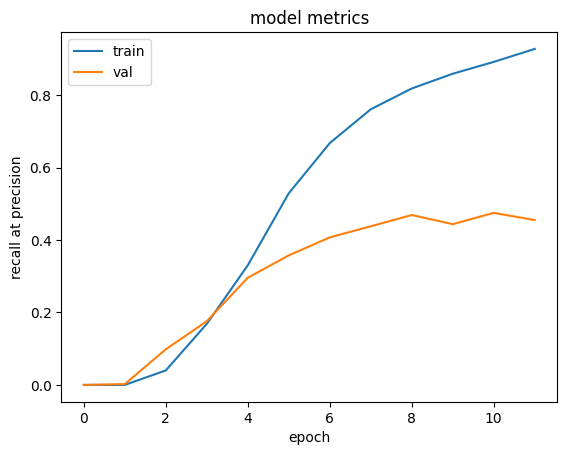

In [17]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history["rec@prec"])
plt.plot(model.history.history["val_rec@prec"])
plt.title("model metrics")
plt.ylabel("recall at precision")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()